<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Общая-информация-о-данных" data-toc-modified-id="Общая-информация-о-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Общая информация о данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Моделирование" data-toc-modified-id="Моделирование-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Моделирование</a></span></li><li><span><a href="#Анализ-результатов-прогноза" data-toc-modified-id="Анализ-результатов-прогноза-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Анализ результатов прогноза</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Транспортная компания, оказывающая услуги такси, предоставила исторические данные о заказах такси в аэропортах. 

Цель исследования - построить модель, предсказывающую количество заказов такси на следующий час. Это позволит привлекать больше водителей в период пиковой нагрузки.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Ход исследования:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Общая информация о данных

In [3]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error


RS = 12345

In [4]:
# загрузка временного ряда

data = pd.read_csv('/datasets/taxi.csv')

In [5]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [7]:
data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y-%m-%dT%H:%M:%S')

In [8]:
data = data.set_index('datetime')

In [9]:
data = data.sort_index()

In [10]:
#проверка хронологического порядка дат

data.index.is_monotonic

True

In [11]:
data.isna().sum()

num_orders    0
dtype: int64

In [12]:
data = data.resample('1H').sum()

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Вывод п. 1.** Загружены исторические данные о заказах такси (анализируемый период с 1 марта по 31 августа 2018 г, частота данных - 10 мин.). Данные представлены в виде временного ряда. Приведены типы данных к корректным. Проверена сортировка данных по времени. Проведено ресемплирование по одному часу, агрегируя значения как сумма заказов в час. </font>

## Анализ данных

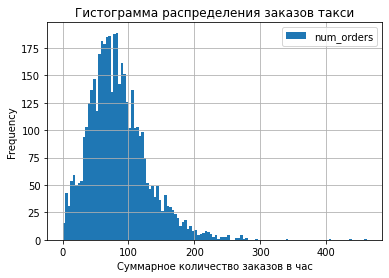

In [14]:
data.plot(y='num_orders', kind='hist', bins=120, grid=True, title = 'Гистограмма распределения заказов такси')
plt.xlabel('Суммарное количество заказов в час');

In [15]:
decomposed = seasonal_decompose(data) 

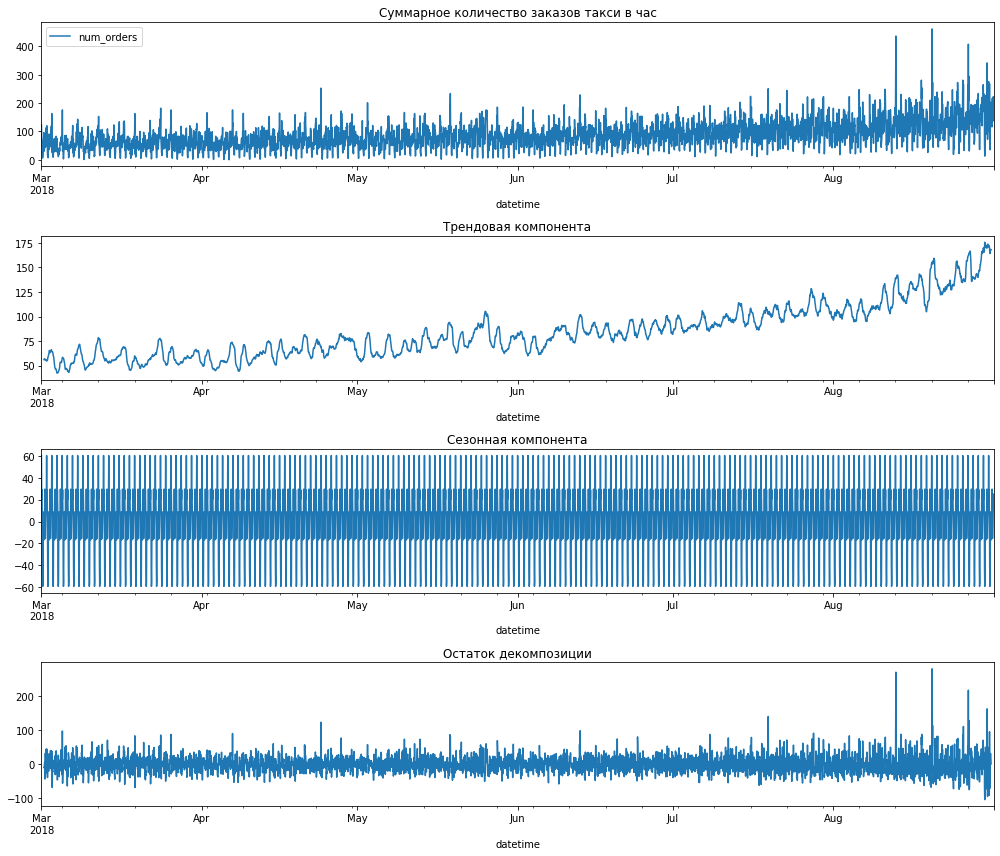

In [16]:
plt.figure(figsize=(14, 12))
plt.subplot(411)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
data.plot(ax=plt.gca())
plt.title('Суммарное количество заказов такси в час')
plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Трендовая компонента')
plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонная компонента')
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции')
plt.tight_layout()

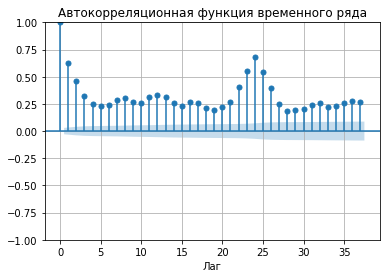

In [17]:
plot_acf(data, title = 'Автокорреляционная функция временного ряда')
plt.xlabel('Лаг')
plt.grid(True);

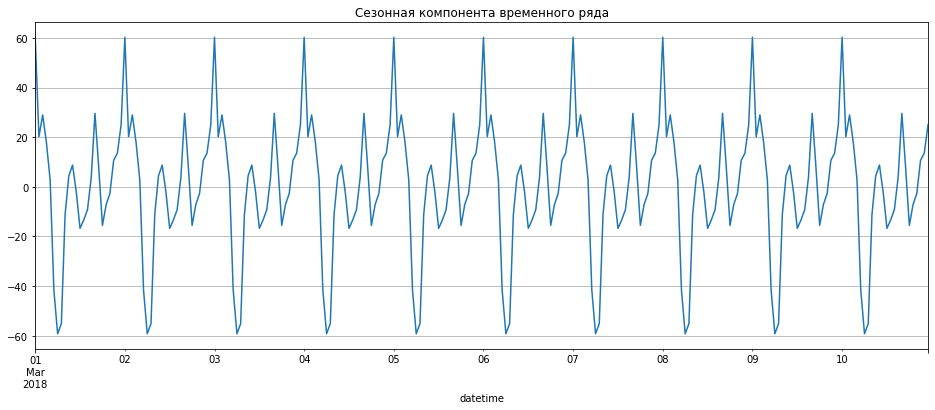

In [18]:
decomposed.seasonal['2018-03-01':'2018-03-10'].plot(figsize = (16,6), grid = True, 
                                                    title = 'Сезонная компонента временного ряда');

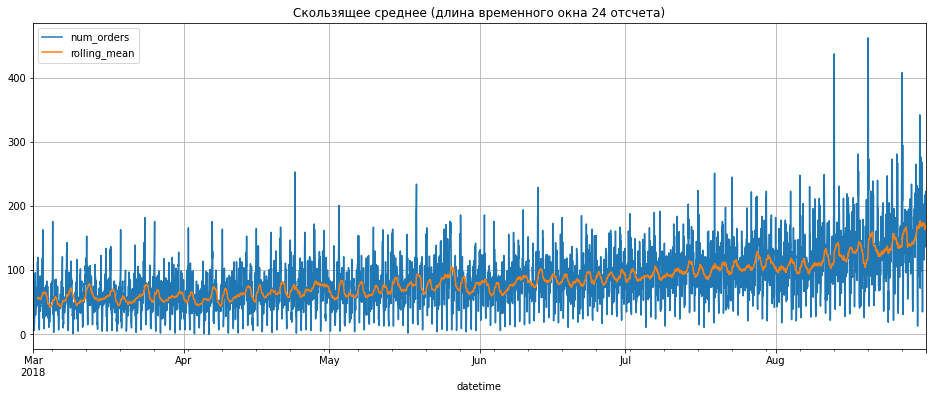

In [19]:
data['rolling_mean'] = data.rolling(24).mean()
data.plot(figsize = (16,6), grid = True, title = 'Скользящее среднее (длина временного окна 24 отсчета)');

In [20]:
data = data.drop(['rolling_mean'], axis = 1)

<font size = 4> **Вывод п. 2.** В целом данные имеют распределение близкое к нормальному. Во временном ряде присутствует восходящая трендовая составляющая, которая сильнее выражена для июля и августа. Это необходимо учитывать при интерпретации результатов моделирования. Наблюдаемый восходящий тренд в летние месяцы скорее всего связан с увеличением полетов в этот период. Сезонная компонента показывает наличие суточного хода: утренние часы показывают наименьшее количество заказов, вечерние часы - наибольшее количество заказов. АКФ подтверждает суточный ход: на 24-м лаге есть сильная автокорреляция, а положительные значения АКФ подтверждают наличие тренда. Присутствие тренда и сезонной компонент, а также отсутствие быстрого затухания у АКФ ряда говорит о его нестационарности.</font>

## Обучение моделей

 ### Создание признаков
 
Данные предоставлены только за полгода 2018 г., поэтому выявить какую-либо сезонную зависимость от месяца и года нельзя. В качестве признаков будем рассматривать день недели и час. Также в качестве признаков добавим лаг и скользящее среднее (для понимания общего тренда и его направления). Учитывая анализ АКФ, рассмотрим лаг до 24. Наиболее логично взять размер временного окна в 24 отсчета.

In [21]:
# функция для создания признаков

def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna(inplace=True)

In [22]:
make_features(data, 24, 24)
data.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,1,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,3,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


In [23]:
data.corr()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
num_orders,1.000000,4.184469e-03,-1.967969e-02,0.623635,0.464652,0.320341,0.247929,0.230075,0.237952,0.290977,...,0.274209,0.257994,0.212323,0.198838,0.219859,0.267209,0.406704,0.557188,0.691576,0.553520
hour,0.004184,1.000000e+00,9.016515e-18,-0.076343,-0.120093,-0.154237,-0.145387,-0.122258,-0.072605,-0.098803,...,-0.079130,0.098152,0.288538,0.422403,0.415302,0.356892,0.264005,0.198878,0.004107,0.006388
dayofweek,-0.019680,9.016515e-18,1.000000e+00,-0.027398,-0.029637,-0.029124,-0.028762,-0.028816,-0.026970,-0.026969,...,-0.005012,-0.002613,-0.000618,-0.001593,0.000121,0.000522,0.011791,0.021076,0.030720,-0.025997
lag_1,0.623635,-7.634273e-02,-2.739777e-02,1.000000,0.622802,0.464194,0.319795,0.247556,0.228818,0.236671,...,0.236451,0.275097,0.259039,0.212732,0.196972,0.219879,0.265786,0.405796,0.555999,0.574792
lag_2,0.464652,-1.200933e-01,-2.963693e-02,0.622802,1.000000,0.622407,0.463626,0.319214,0.246069,0.227058,...,0.257041,0.237026,0.275875,0.259062,0.210322,0.196882,0.218036,0.264518,0.404142,0.578336
lag_3,0.320341,-1.542371e-01,-2.912407e-02,0.464194,0.622407,1.000000,0.622205,0.463440,0.318570,0.245333,...,0.310866,0.257534,0.237624,0.276076,0.258145,0.210295,0.195970,0.217318,0.263419,0.582082
lag_4,0.247929,-1.453869e-01,-2.876173e-02,0.319795,0.463626,0.622205,1.000000,0.622095,0.463010,0.318001,...,0.329318,0.311367,0.258134,0.237855,0.275308,0.258136,0.209482,0.195282,0.216184,0.585526
lag_5,0.230075,-1.222580e-01,-2.881556e-02,0.247556,0.319214,0.463440,0.622095,1.000000,0.621994,0.462865,...,0.314624,0.329808,0.311946,0.258446,0.237414,0.275317,0.257668,0.208992,0.194383,0.587400
lag_6,0.237952,-7.260523e-02,-2.697046e-02,0.228818,0.246069,0.318570,0.463010,0.621994,1.000000,0.621294,...,0.259183,0.315449,0.330809,0.312287,0.256632,0.237428,0.273865,0.256529,0.206857,0.588708
lag_7,0.290977,-9.880316e-02,-2.696950e-02,0.236671,0.227058,0.245333,0.318001,0.462865,0.621294,1.000000,...,0.265312,0.260259,0.316754,0.331444,0.310559,0.256719,0.235788,0.272637,0.254192,0.589727


In [24]:
# выбрали признаки по корреляции

data = data[['num_orders', 'hour', 'dayofweek', 'lag_1', 'lag_2', 'lag_22', 'lag_23', 'lag_24']]

In [25]:
features = data.drop(['num_orders'], axis = 1)
target = data['num_orders']

In [26]:
# выделение тестовой выборки

features_com, features_test, target_com, target_test = train_test_split(features, target, 
                                                                        shuffle=False, test_size=0.1, random_state = RS)

# выделение обучающей и валидационной выборки

features_train, features_valid, target_train, target_valid = train_test_split(features_com, target_com, 
                                                                              shuffle=False, test_size=0.1, random_state = RS)

In [29]:
print('Размер обучающей выборки:', target_train.shape[0])
print('Размер валидационной выборки:', target_valid.shape[0])
print('Размер тестовой выборки:', target_test.shape[0])

Размер обучающей выборки: 3556
Размер валидационной выборки: 396
Размер тестовой выборки: 440


**Масштабирование признаков**

In [30]:
# скрываем предупреждение Python

pd.options.mode.chained_assignment = None

# масштабируем признаки выборок

numeric = features.columns.to_list()

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Моделирование

**Модель линейная регрессия**

In [31]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

CPU times: user 6.83 ms, sys: 1.12 ms, total: 7.94 ms
Wall time: 4.6 ms


LinearRegression()

In [32]:
lr_predict = model_lr.predict(features_valid)
rmse_lr = mean_squared_error(target_valid, lr_predict)**0.5
print('RMSE модели линейной регресии:', rmse_lr)

RMSE модели линейной регресии: 35.163675644166524


**Модель случайный лес в регрессии**

In [33]:
%%time

model_rf = None
best_result = 48
best_est = 0
best_depth = 0

for est in range(50, 201, 5):
    for depth in range (2, 21, 2):
        model = RandomForestRegressor(random_state=RS, n_estimators=est, max_depth=depth, n_jobs = -1)
        model.fit(features_train, target_train) 
        predictions_valid = model.predict(features_valid) 
        result = mean_squared_error(target_valid, predictions_valid)**0.5 
        if result < best_result:
            model_rf = model
            best_result = result
            best_est = est
            best_depth = depth

print("RMSE наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

RMSE наилучшей модели на валидационной выборке: 34.38034749256871 Количество деревьев: 105 Максимальная глубина: 20
CPU times: user 5min 48s, sys: 914 ms, total: 5min 49s
Wall time: 5min 49s


In [34]:
rf_predict = model_rf.predict(features_valid)
rmse_rf = mean_squared_error(target_valid, rf_predict)**0.5
print('RMSE модели случайный лес в регресии:', rmse_rf)

RMSE модели случайный лес в регресии: 34.38034749256871


**Модель LightGBM**

In [35]:
%%time

cv_timeseries = TimeSeriesSplit(n_splits=3).split(features_train)

model_lgbm = LGBMRegressor(random_state=RS, learning_rate=0.1) 
param_dist = [{'n_estimators': [50, 100, 130], 'max_depth': range(2, 17, 2)}]

param_gs= GridSearchCV(model_lgbm, param_dist, scoring='neg_mean_squared_error', cv=cv_timeseries)
param_gs.fit(features_train, target_train)
print(param_gs.best_params_)

{'max_depth': 4, 'n_estimators': 100}
CPU times: user 1min 3s, sys: 651 ms, total: 1min 4s
Wall time: 1min 5s


In [36]:
model_lgbm = LGBMRegressor(random_state=RS, learning_rate=0.1, max_depth=4, n_estimators=100) 
model_lgbm.fit(features_train, target_train)
lgbm_predict = model_lgbm.predict(features_valid)
rmse_lgbm = mean_squared_error(target_valid, lgbm_predict)**0.5
print('RMSE модели LightGBM:', rmse_lgbm)

RMSE модели LightGBM: 33.90297997618062


### Анализ результатов прогноза

In [37]:
conclusion = {'RMSE': [rmse_lr, rmse_rf, rmse_lgbm]}
df_concl = pd.DataFrame(conclusion, index = ['Модель линейной регрессии', 'Модель случайный лес', 'Модель LightGBM'])
df_concl

,RMSE
Модель линейной регрессии,35.163676
Модель случайный лес,34.380347
Модель LightGBM,33.902980


In [38]:
# датафреймы с целевыми признаками и их прогнозами

df_lr = pd.DataFrame({'target': target_valid, 'predict': lr_predict})
df_rf = pd.DataFrame({'target': target_valid, 'predict': rf_predict})
df_lgbm = pd.DataFrame({'target': target_valid, 'predict': lgbm_predict})

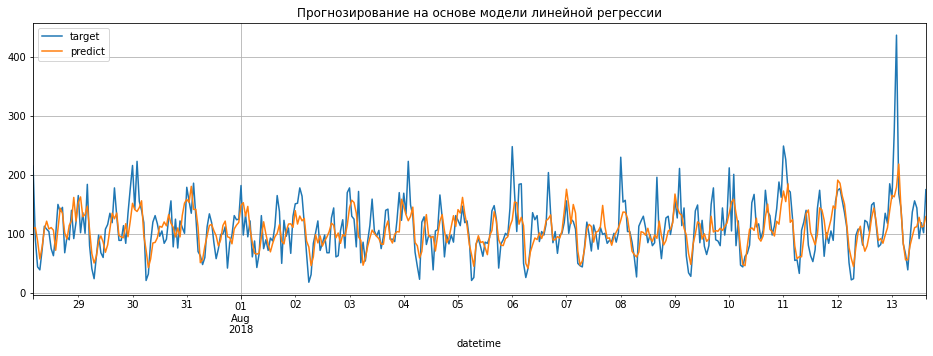

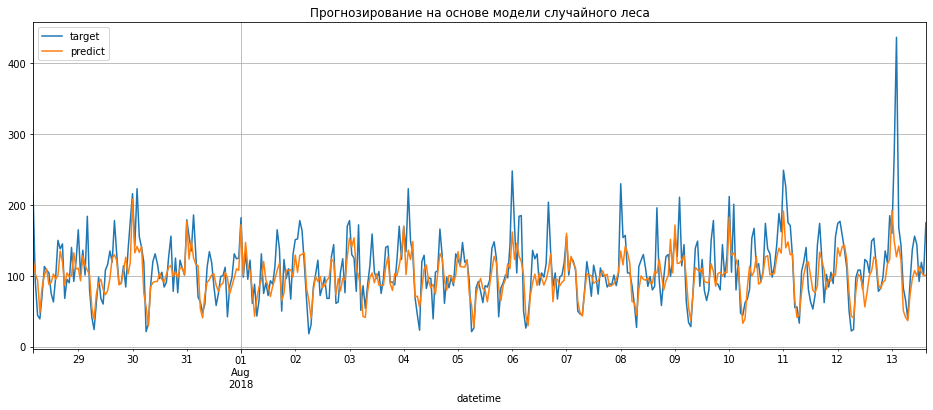

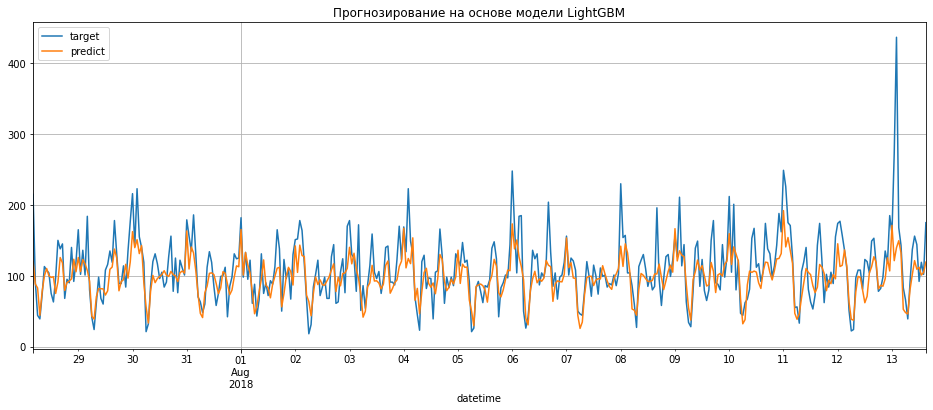

In [39]:
df_lr.plot(kind='line', grid=True, title = 'Прогнозирование на основе модели линейной регрессии', figsize=(16, 5))
df_rf.plot(kind='line', grid=True, title = 'Прогнозирование на основе модели случайного леса', figsize=(16, 6))
df_lgbm.plot(kind='line', grid=True, title = 'Прогнозирование на основе модели LightGBM', figsize=(16, 6));

<font size = 4> **Вывод п. 3.** Полученная на валидационной выборке метрика RMSE в пределах требуемого значения (меньше 48) для всех рассмотренных моделей. Наилучшие результаты по метрике RMSE показала модель LightGBM. Анализ графиков прогноза показывает, что все модели плохо аппроксимируют пики, присутствующие во временном ряде.</font>

## Тестирование

Тестирование будем проводить на модели LightGBM. Перед тестированием увеличим обучающую выборку путем ее объединения с валидационной.

In [40]:
# объединим валидационную и обучающую выборки

features_concat = pd.concat([features_train, features_valid], ignore_index=True)
target_concat = pd.concat([target_train, target_valid], ignore_index=True)

In [41]:
%%time

model_lgbm = LGBMRegressor(random_state=RS, learning_rate=0.1, max_depth=4, n_estimators=100) 
model_lgbm.fit(features_concat, target_concat)

lgbm_predict_test = model_lgbm.predict(features_test)
rmse_lgbm = mean_squared_error(target_test, lgbm_predict_test)**0.5
print('RMSE модели LightGBM:', rmse_lgbm)

RMSE модели LightGBM: 44.70245293013084
CPU times: user 1.63 s, sys: 8.8 ms, total: 1.64 s
Wall time: 1.57 s


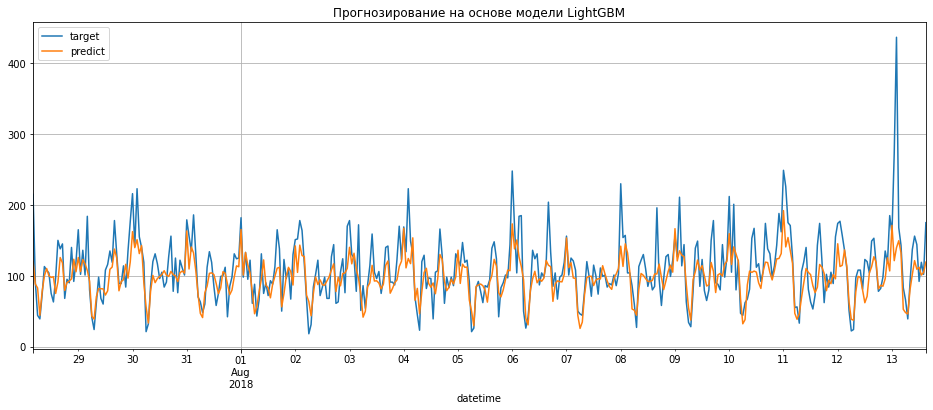

In [42]:
df_lgbm_test = pd.DataFrame({'target': target_test, 'predict': lgbm_predict_test})
df_lgbm.plot(kind='line', grid=True, title = 'Прогнозирование на основе модели LightGBM', figsize=(16, 6));

**Сравнение с Dummy**

In [43]:
dummy = DummyRegressor(strategy='mean').fit(features_concat, target_concat)
predicted_dummy = dummy.predict(features_test)
rmse_dummy = mean_squared_error(target_test, predicted_dummy)**0.5
print('RMSE dummy:', rmse_dummy)

RMSE dummy: 84.68768287118466


## Общий вывод

Исследование посвящено построению модели для прогнозирования заказов такси в аэропортах. Горизонт прогноза 1 час, используемая метрика RMSE должна быть не более 48, объем тестовой выборки 10%.

1. Выполнен анализ предоставленных данных (ресемплирование, декомпозиция на компоненты: тренд, сезонная составляющая и остатки, анализ автокорреляционной функции). Анализ показал, что данные нестационарные,имеют трендовую и сезонную компоненты. Восходящий тренд ярко выражен в летние месяцы. Сезонная компонента показала наличие суточного хода. Анализ АКФ показал сильную корреляцию для 1 и 24 лагов.
2. Выполнена подготовка признаков (созданы признаки, данные разбиты на три выборки, выполнено масштабирование количественных признаков).
3. Исследовано три модели:

- линейная регрессия,
- случайный лес,
- LightGMB

Учитывая критерии заказчика, в качестве наилучшей модели выбрана LightGMB. Проверка модели на тестовой выборке и ее сравнение с Dummy моделью, подтвердило ее адекватность. Анализ графиков целевого признака и прогноза показал, что все используемые модели плохо аппроксимируют пики, присутствующие во временном ряде. Возможно стоит взять разность первого порядка для стационарности ряда и рассмотреть модель временных рядов ARIMA, SARIMA для получения более лучших результатов.